In [12]:
%matplotlib inline
from hyperopt.mongoexp import MongoTrials
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
exp_type = 'svr_nonlin' #ridge_nonlin_cweight
db_path = 'mongo://localhost:1234/' + exp_type + '/jobs'
trials = MongoTrials(db_path)

ftp://localhost:1234/svr_nonlin/jobs
ParseResult(scheme='ftp', netloc='localhost:1234', path='/svr_nonlin/jobs', params='', query='', fragment='')


In [4]:
len(trials.results)

500

In [5]:
total_time = trials.results[-3]['eval_time'] - trials.results[0]['eval_time']
mean_time = total_time/float(len(trials.results))
print total_time, mean_time

29969.088634 59.938177268


In [6]:
dict(trials.best_trial['misc']['vals']), trials.best_trial['result']['loss'], trials.best_trial['tid']

({u'c3d_gamma': [0.7448057839668178],
  u'hof_gamma': [0.07271759288516493],
  u'hog_gamma': [0.10584102051488271],
  u'mbhx_gamma': [0.14148162765679317],
  u'mbhy_gamma': [18.297798578093797],
  u'svr_C': [5.612053092224692],
  u'traj_gamma': [0.03973091601387516]},
 0.39232548677316226,
 268)

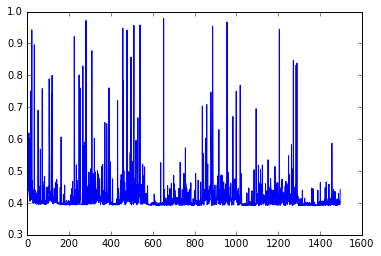

In [125]:
#plot losses through trials
res = [r['result']['loss'] for r in trials.trials[:-3]]
plt.plot(res)

In [7]:
#plot only the new bests
best = np.inf
best_hist = []
loss_hist = []
for tid, t in enumerate(trials.trials):
    l = t['result']['loss']
    if l < best:
        best = l
        loss_hist.append([l, tid])
        best_hist.append([l, tid])
    else:
        loss_hist.append([best, tid])
loss_hist_array = np.array(loss_hist)
best_hist_array = np.array(best_hist)

In [8]:
def plot_optimisation(ax, num_trials, loss_hist_array, best_hist_array, alpha=1):
    ax.plot(loss_hist_array[:num_trials,1], 1-loss_hist_array[:num_trials,0], 'k--', alpha=alpha)
    ax.plot(best_hist_array[:num_trials,1], 1-best_hist_array[:num_trials,0], 'ro', alpha=alpha)
    ax.set_xlabel('Optimisation trial')
    ax.set_ylabel('Cross-validation $R^2$')
    ax.grid()
    return ax

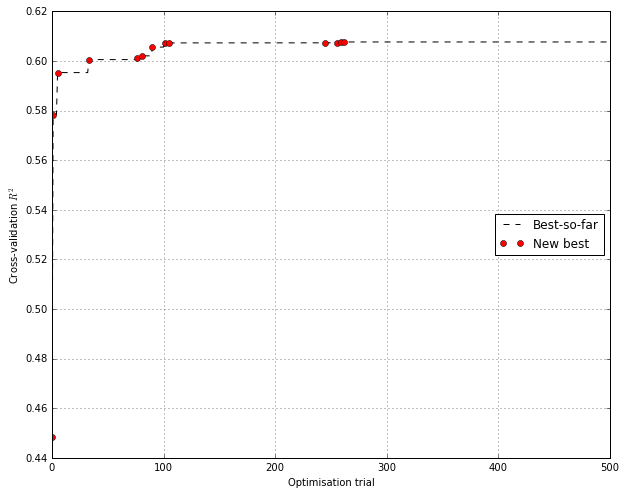

In [9]:
#plot, with and without val acc
f, ax = plt.subplots(figsize=(10,8))
num_trials = 500
ax = plot_optimisation(ax, num_trials, loss_hist_array, best_hist_array, alpha=1)
ax.legend(['Best-so-far', 'New best'], loc='center right')

## Analysis with validation

In [13]:
#train the best model on the whole set
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics.pairwise import linear_kernel
from sklearn.externals import joblib
from multichannel import MultiChannelModel, multichannel_KFoldCV#, theano_rbf as rbf_kernel, theano_chi2 as chi2_kernel
import numpy as np
import csv, os, time

#load the dataset
dataset_root = '/home/luke/projects/THE_dataset' #directory where features/labels kept
train_path = os.path.join(dataset_root, 'train_set_wc3d.pkl')
test_path = os.path.join(dataset_root, 'test_set_wc3d.pkl')
X_train, y_train = joblib.load(train_path)
X_test, y_test = joblib.load(test_path)

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)


In [14]:
#from sklearn.metrics.pairwise import chi2_kernel, rbf_kernel #using CPU as GPU doing experiments!
from multichannel import theano_rbf as rbf_kernel, theano_chi2 as chi2_kernel
def create_kpt(num_channels, gammas):
    kernel_param_list = []
    for channel in xrange(num_channels):
        if channel < 4:
            kdict = {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gammas[channel]}}
        elif channel == 5:
            kdict = {'kernel_func': rbf_kernel, 'param_dict': {'gamma': gammas[channel]}}
        kernel_param_list.append(kdict)
    kernel_param_tuple = tuple(kernel_param_list)
    return kernel_param_tuple

In [15]:
def extract_config(trials, tid, return_code=0):
    if tid == 'best':
        best_config = dict(trials.best_trial['misc']['vals'])
    else:
        best_config = dict(trials.trials[tid]['misc']['vals'])
        
    if return_code == 0:
        alpha = best_config['svr_C'][0]
        kpt = {'kernel_func': linear_kernel, 'param_dict':{}}
        cw = None
        return alpha, kpt, None
    elif return_code == 1:
        gammas = [best_config['traj_gamma'][0], best_config['hog_gamma'][0], best_config['hof_gamma'][0], 
                  best_config['mbhx_gamma'][0], best_config['mbhy_gamma'][0], best_config['c3d_gamma'][0]]
        kpt = create_kpt(6, gammas)
        alpha = best_config['svr_C'][0]
        return alpha, kpt, None
    elif return_code == 2:
        gammas = [best_config['traj_gamma'][0], best_config['hog_gamma'][0], best_config['hof_gamma'][0], 
                  best_config['mbhx_gamma'][0], best_config['mbhy_gamma'][0], best_config['c3d_gamma'][0]]
        kpt = create_kpt(6, gammas)
        cw = [best_config['traj_cw'][0], best_config['hog_cw'][0], best_config['hof_cw'][0], 
              best_config['mbhx_cw'][0], best_config['mbhy_cw'][0], best_config['c3d_cw'][0]]
        alpha = best_config['ridge_alpha'][0]
        return alpha, kpt, cw
    elif return_code == 3:
        gammas = [0.06386, 0.117941, 0.060457, 0.180092, 3405.482, 0.79326]
        cw = [best_config['traj_cw'][0], best_config['hog_cw'][0], best_config['hof_cw'][0], 
              best_config['mbhx_cw'][0], best_config['mbhy_cw'][0], best_config['c3d_cw'][0]]
        kpt = create_kpt(6, gammas)
        alpha = best_config['ridge_alpha'][0]
        return alpha, kpt, cw
    else:
        ValueError('incorrect return code supplied')

In [16]:
t0 = time.time()
alpha, kpt, cw = extract_config(trials, tid='best', return_code=1)
model = SVR(kernel='precomputed', C=alpha)
#model = Ridge(alpha=alpha)
mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt, channel_weights=cw)
mcm.fit(X_train, y_train)
t1 = time.time()-t0
score = mcm.score(X_test, y_test)
t2 = time.time()-t0-t1
print 'Final corrcoef = {0}. Training time = {1}. Testing time = {2}'.format(np.sqrt(score), t1, t2)

Final corrcoef = 0.790921252164. Training time = 12.7372319698. Testing time = 6.87747001648


In [17]:
print score

0.625556427125


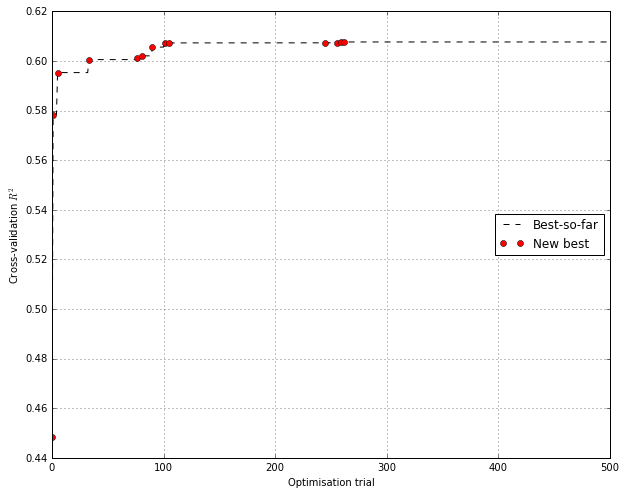

In [18]:
#plot, with and without val acc
f, ax = plt.subplots(figsize=(10,8))
ax = plot_optimisation(ax, num_trials, loss_hist_array, best_hist_array)
ax.legend(['Best-so-far', 'New best'], loc='center right')

In [31]:
#calc validation scores
val_hist=[]
for t in best_hist_array:
    tid = int(t[1])
    alpha, kpt, cw = extract_config(trials, tid=tid, return_code=1)
    #model = Ridge(alpha=alpha)
    model = SVR(kernel='precomputed', C=alpha)
    mcm = MultiChannelModel(num_channels=6, model=model, kernel_param_tuple=kpt, channel_weights=cw)
    mcm.fit(X_train, y_train)
    score = mcm.score(X_test, y_test)
    val_hist.append([score, tid])
    print alpha, score
val_hist_array = np.array(val_hist)

2.5313692512 0.514460755563
2.10351299382 0.630115034576
0.715045658196 0.624798771534
1.44226494163 0.638162537133
1.37026893514 0.628789257449
1.68169856405 0.626091461354
2.40693126997 0.625622263878
6.08241983236 0.626524292054
6.33840855121 0.624721788564
6.99712295691 0.623755675792
5.58945492992 0.626880915824
5.57424920639 0.624606567289
5.61205309222 0.625556427125


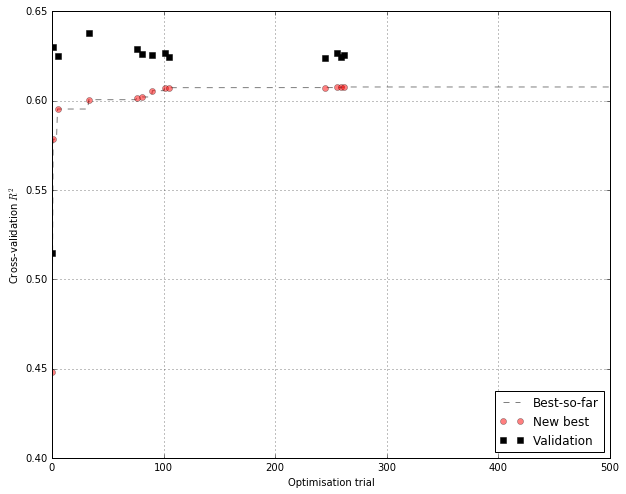

In [32]:
f, ax = plt.subplots(figsize=(10,8))
ax = plot_optimisation(ax, num_trials, loss_hist_array, best_hist_array, alpha=.5)
ax.plot(val_hist_array[:,1], val_hist_array[:,0], 'ks')
#ax.set_ylim([.45, .6])
ax.legend(['Best-so-far', 'New best', 'Validation'], loc='lower right')

In [33]:
[np.sqrt(x) for x in val_hist_array[:,0]]

[0.71725919691765583,
 0.7937978549835476,
 0.79044213673997354,
 0.79885076023835722,
 0.79296233040953912,
 0.79125941470177652,
 0.79096287136513355,
 0.79153287490393764,
 0.79039343909495918,
 0.78978204321937329,
 0.79175811699271958,
 0.79032054717598299,
 0.79092125216419729]

In [34]:
#save the loss/best/val hist arrays
results_hist = {'loss': loss_hist_array, 'best': best_hist_array, 'val_of_best': val_hist_array}
save_root = 'results/' + exp_type
if not os.path.isdir(save_root):
    os.makedirs(save_root)
save_name = 'search_histories.pkl'
save_path = os.path.join(save_root, save_name)
joblib.dump(results_hist, save_path)

['results/svr_nonlin/search_histories.pkl',
 'results/svr_nonlin/search_histories.pkl_01.npy',
 'results/svr_nonlin/search_histories.pkl_02.npy',
 'results/svr_nonlin/search_histories.pkl_03.npy']

In [30]:
dict(trials.trials[262])

{u'_id': ObjectId('572b3aab510eac6b0a5e631b'),
 u'book_time': datetime.datetime(2016, 5, 5, 12, 21, 48, 443000),
 u'exp_key': None,
 u'misc': SON([(u'tid', 268), (u'idxs', SON([(u'hof_gamma', [268]), (u'svr_C', [268]), (u'mbhy_gamma', [268]), (u'hog_gamma', [268]), (u'traj_gamma', [268]), (u'c3d_gamma', [268]), (u'mbhx_gamma', [268])])), (u'cmd', [u'domain_attachment', u'FMinIter_Domain']), (u'vals', SON([(u'hof_gamma', [0.07271759288516493]), (u'svr_C', [5.612053092224692]), (u'mbhy_gamma', [18.297798578093797]), (u'hog_gamma', [0.10584102051488271]), (u'traj_gamma', [0.03973091601387516]), (u'c3d_gamma', [0.7448057839668178]), (u'mbhx_gamma', [0.14148162765679317])])), (u'workdir', None)]),
 u'owner': [u'nilli15:5524'],
 u'refresh_time': datetime.datetime(2016, 5, 5, 12, 22, 37, 202000),
 u'result': SON([(u'status', u'ok'), (u'loss', 0.39232548677316226), (u'eval_time', 1462450957.201771)]),
 u'spec': None,
 u'state': 2,
 u'tid': 268,
 u'version': 3}

In [24]:
best_hist_array

array([[   0.55167367,    0.        ],
       [   0.42158446,    1.        ],
       [   0.40467205,    5.        ],
       [   0.39943301,   33.        ],
       [   0.3986408 ,   76.        ],
       [   0.39792349,   81.        ],
       [   0.39438685,   90.        ],
       [   0.3927082 ,  101.        ],
       [   0.39267542,  105.        ],
       [   0.39265389,  245.        ],
       [   0.39258842,  255.        ],
       [   0.39241842,  259.        ],
       [   0.39232549,  262.        ]])